In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.express as px
import json

user_df = pd.read_csv('data/user_data.csv')
cluster_cols = ['trip_ct', 'is_winter', 'is_night','one_way', 'duration']
X = user_df.loc[:, cluster_cols].fillna(-1).values

## Introduction
We were interested in how user patterns might vary between Omaha and Lincoln. Omaha is a larger city (metro population of about one million people), whereas Lincoln is about a quarter of the size and a college town. To compare users, we first filtered out admin and other invalid trips. Most of the available data pertains to time, so we made maximum use of the timestamps. We considered if a person made a trip in the winter (defined as December, January, February, and March) as a measure of their being an all-season cyclist. We also considered if they biked at night. Nightfall is a bit of a tricky variable. Fortunately, the Python `suntime` package can give us the sunrise and sunset time on any day, adjusting for latitude and daylight saving time. We consider whether a trip is one-way, meaning it returns to the same station at which it started its trip. This variable provides an indication of if the trip was utilitarian or recreational. Finally, we consider the trip count and average duration of trips by user.

## Perform Siloutte Analysis To Define K Value for K-Means Clustering
We use the k-means clustering to define user groups. This algorithm clusters observations (in our case users) in order to maximize the cross-cluster variation in the input *features*. Our *features* are defined by the variables described above. We use siloutte analysis to find the optimal number of clusters. The silhouette value is a measure of how similar an observation is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. Our results suggest the that four clusters are ideal here.


For n_clusters = 2 The average silhouette_score is : 0.4653705024493721
For n_clusters = 3 The average silhouette_score is : 0.48854051475775756
For n_clusters = 4 The average silhouette_score is : 0.5065985416901237
For n_clusters = 5 The average silhouette_score is : 0.4497914115339878
For n_clusters = 6 The average silhouette_score is : 0.4615478858524191


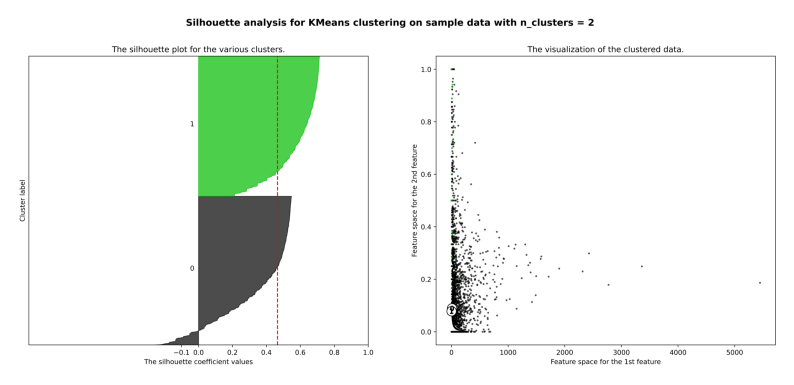

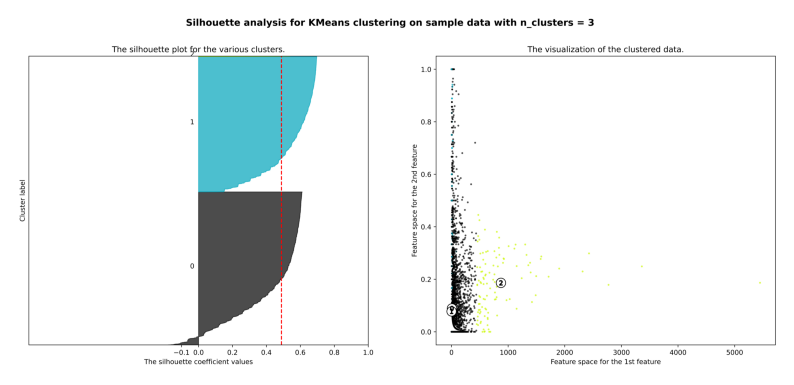

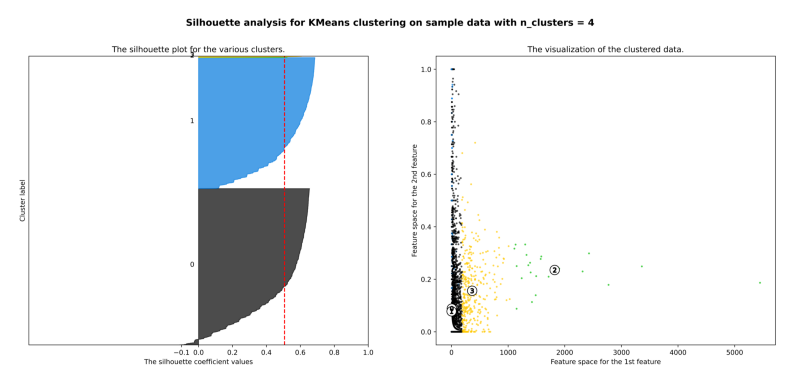

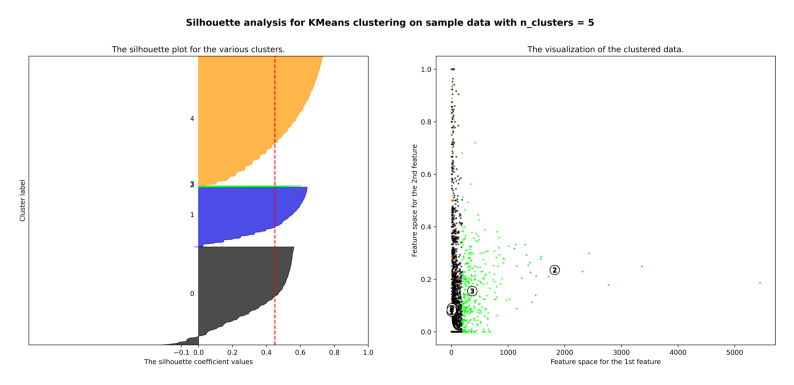

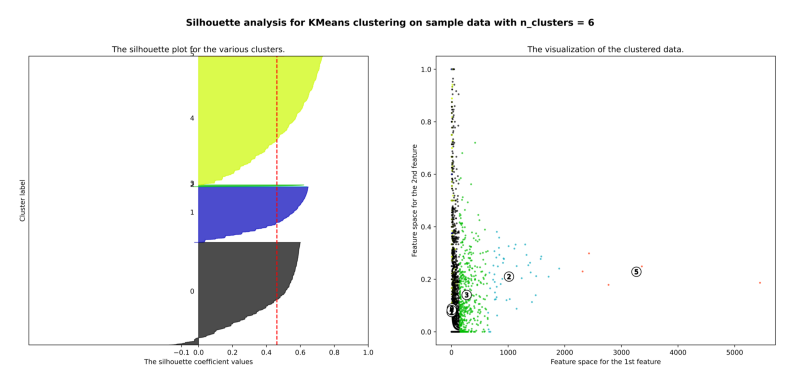

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import json
import os


run_K_mean_silhouette = False

cluster_details = {}

if run_K_mean_silhouette:

    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        cluster_details[n_clusters] = {
            "silhouette_score": silhouette_avg,
        }

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" %
                        i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        # Save the figure
        os.makedirs('kmeans_silhouette_plots', exist_ok=True)
        fig_width = 20  # Set the figure width to 20 inches
        aspect_ratio = fig.get_figheight() / fig.get_figwidth()
        fig_height = fig_width * aspect_ratio
        fig.set_size_inches(fig_width, fig_height)
        plt.savefig(
            f'kmeans_silhouette_plots/silhouette_score_{n_clusters}.png', dpi=700, bbox_inches='tight', pad_inches=0.2)
        plt.close(fig)

    with open('data/cluster_details.json', 'w') as f:
        json.dump(cluster_details, f)

else:
    try:
        with open('data/cluster_details.json', 'r') as f:
            cluster_details = json.load(f)

        for i in cluster_details:
            print(f"For n_clusters = {i} The average silhouette_score is : {cluster_details[i]['silhouette_score']}",)

        for i in cluster_details:
            # read the image file
            img = plt.imread(
                f'kmeans_silhouette_plots/silhouette_score_{i}.png')
            # display the image with resizing
            aspect_ratio = img.shape[1] / img.shape[0]

            # Set the width and calculate height to maintain aspect ratio
            plt.figure(figsize=(10, 10 * aspect_ratio))

            plt.imshow(img)
            plt.axis('off')
            plt.show()


            fig.show()

    except Exception as e:
        print(e)
        print('Error reading cluster_details.json file. Please run the script with run_K_mean_silhouette=True to generate the file.')

## K-Means Clustering for Four Clusters


In [20]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=10).fit(X)

# Add cluster labels to DataFrame
user_df['cluster'] = kmeans.labels_

# Group data by cluster and count the size of each cluster
grp_df = user_df.groupby(["city","cluster"]).size()
# grp_df
grp_df = grp_df.reset_index().pivot_table(index="city",columns="cluster", aggfunc="sum")
# Get sum of each row (total value per country)
total_values = grp_df.sum(axis=1)
# Calculate percentages for each value relative to row total
grp_df = grp_df.div(total_values, axis=0).mul(100)
grp_df = grp_df.unstack().droplevel(0).reset_index()
grp_df.rename(columns={0:"proportion"}, inplace=True)

# Sort index for plotting
grp_df = grp_df.sort_index()
grp_df["cluster"] = grp_df["cluster"].astype(str)

# Create bar chart
fig = px.bar(grp_df, x='city', y='proportion', color="cluster")
fig.update_xaxes(title_text='City')
fig.update_yaxes(title_text='% of users')
# plt.title('Cluster Distribution')
# plt.legend()

fig.show()


# Describing The Clusters
With four clusters and the above descriptive statistics, we can define the clusters as follows:
Cluster 0 (Local infrequency): These are occassional users who do not use the system during the winter. They may use it during the evening.
Cluster 1 (Tourist): These are occassional users who do not use the system during the winter. They may use it during the evening. They differ from Cluster 0 in that they are more likely to make one-way trips and make slightly fewer trips.
Cluster 2 (Frequent): These are the most frequent users of the system. They make many trips and are likely to make a trip during the winter months.
Clsuter 3 (Frequent social): These are frequent users of the system. They are slightly more likely to make one-way and night trips than Cluster 2 users.


In [12]:
def describe_by_group(grouped_df): 
    descriptions = []
    for name, group in grouped_df:
        descriptions.append(group.describe()) 
    return descriptions

grouped_df = user_df.groupby('cluster')
descriptions = describe_by_group(grouped_df)

from IPython.display import display, Markdown
for i in descriptions:
    display(Markdown(i.to_markdown()))
print("\n")

|       |          user_id |     trip_ct |     is_winter |     is_night |      one_way |    duration |   cluster |
|:------|-----------------:|------------:|--------------:|-------------:|-------------:|------------:|----------:|
| count |  42836           | 42836       | 42836         | 42836        | 42836        | 42836       |     42836 |
| mean  | 805849           |     5.89523 |     0.0884465 |     0.25797  |     0.532147 |    24.2404  |         0 |
| std   |      1.24851e+06 |    15.7375  |     0.266521  |     0.403309 |     0.465253 |     9.93219 |         0 |
| min   |      3           |     1       |     0         |     0        |     0        |     2       |         0 |
| 25%   |  60892.5         |     1       |     0         |     0        |     0        |    16.5     |         0 |
| 50%   | 127630           |     2       |     0         |     0        |     0.555556 |    25.5     |         0 |
| 75%   |      2.0298e+06  |     4       |     0         |     0.5      |     1        |    32.5     |         0 |
| max   |      4.44126e+06 |   185       |     1         |     1        |     1        |    49.2203  |         0 |

|       |          user_id |     trip_ct |     is_winter |     is_night |      one_way |   duration |   cluster |
|:------|-----------------:|------------:|--------------:|-------------:|-------------:|-----------:|----------:|
| count |  35900           | 35900       | 35900         | 35900        | 35900        | 35900      |     35900 |
| mean  | 452890           |     2.47889 |     0.0779591 |     0.20361  |     0.76414  |    55.7638 |         1 |
| std   |      1.01463e+06 |     2.97054 |     0.255467  |     0.385383 |     0.400037 |    12.9453 |         0 |
| min   |      0           |     1       |     0         |     0        |     0        |    40      |         1 |
| 25%   |  45156.2         |     1       |     0         |     0        |     0.583333 |    46      |         1 |
| 50%   |  92721           |     2       |     0         |     0        |     1        |    52.3333 |         1 |
| 75%   | 152512           |     3       |     0         |     0        |     1        |    62      |         1 |
| max   |      4.44121e+06 |   122       |     1         |     1        |     1        |    96      |         1 |

|       |          user_id |   trip_ct |   is_winter |   is_night |     one_way |   duration |   cluster |
|:------|-----------------:|----------:|------------:|-----------:|------------:|-----------:|----------:|
| count |     22           |    22     |  22         | 22         | 22          |   22       |        22 |
| mean  |      1.1339e+06  |  1820.91  |   0.23552   |  0.159872  |  0.0988543  |   13.6594  |         2 |
| std   |      1.15594e+06 |   996.699 |   0.0663609 |  0.110981  |  0.132088   |    8.6342  |         0 |
| min   | 138889           |  1111     |   0.0878261 |  0.0483019 |  0.00126984 |    3.53841 |         2 |
| 25%   | 234859           |  1307.75  |   0.205502  |  0.0686736 |  0.00993912 |    6.66342 |         2 |
| 50%   | 283118           |  1454     |   0.244916  |  0.111485  |  0.0573053  |   11.3514  |         2 |
| 75%   |      2.18189e+06 |  1855.25  |   0.284529  |  0.257867  |  0.12855    |   18.3469  |         2 |
| max   |      3.40367e+06 |  5447     |   0.332565  |  0.404865  |  0.561656   |   33.7786  |         2 |

|       |          user_id |   trip_ct |   is_winter |    is_night |     one_way |   duration |   cluster |
|:------|-----------------:|----------:|------------:|------------:|------------:|-----------:|----------:|
| count |    347           |   347     | 347         | 347         | 347         |  347       |       347 |
| mean  |      1.82272e+06 |   365.585 |   0.156223  |   0.19016   |   0.103283  |   12.6812  |         3 |
| std   |      1.47484e+06 |   182.188 |   0.126897  |   0.130693  |   0.160661  |    8.8064  |         0 |
| min   |  19261           |   186     |   0         |   0         |   0         |    3.68841 |         3 |
| 25%   | 235234           |   230     |   0.0556363 |   0.0815076 |   0.0195956 |    6.7967  |         3 |
| 50%   |      2.22699e+06 |   304     |   0.13215   |   0.182979  |   0.0501882 |    9.26971 |         3 |
| 75%   |      3.16213e+06 |   442.5   |   0.229686  |   0.270637  |   0.113309  |   15.2136  |         3 |
| max   |      4.12381e+06 |  1029     |   0.720096  |   0.669565  |   1         |   49.4857  |         3 |

| Cluster | Statistic | Value |
|---|---|---|
| {{ descriptions }} |

## Potential Additional Dimensions to Explore:
- Use date to get weekday vs. weekend
- Travel speed (duration seems a bit inaccurate for some trips, so may be hard to have confidence, and we do not have route distance)